In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns

In [32]:
sns.set()
plt.rcParams['figure.figsize'] = (15, 10)

In [60]:
input_dirs = ['data/Hybrid_AggressiveHybrid/', 'data/Hybrid_BalancedAdvantage/']
input_files = []
for input_dir in input_dirs:
    input_files.extend([os.path.join(input_dir, file) for file in os.listdir(input_dir) if file.endswith('.csv')])
    
input_files.append('data/Equity_LargeCap/UTINiftyGrowthDirect.csv')

In [61]:
input_files

['data/Hybrid_AggressiveHybrid/CanaraRobecoHybridEquityDirectGrowth.csv',
 'data/Hybrid_AggressiveHybrid/MiraeAssetHybridEquityDirectGrowth.csv',
 'data/Hybrid_BalancedAdvantage/EdelweissBalancedAdvDirectGrowth.csv',
 'data/Equity_LargeCap/UTINiftyGrowthDirect.csv']

In [62]:
fund_names = ['CanaraRobecoHybridEquity', 'MiraeAssetHybridEquity', 'EdelweissBalancedAdv', 'UTINifty50Index']

In [63]:
def read_fund_info(file_name, fund_name, start_date, end_date):
    df = pd.read_csv(file_name, skiprows=4)
    df = df[['NAV date', 'Net Asset Value']]
    df['NAV date'] = pd.to_datetime(df['NAV date'], infer_datetime_format=True)
    df.columns = ['date', f'{fund_name}_NAV']
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    df = df.dropna()
    return df

def calculate_rolling_returns(df, fund_name, num_years, num_trading_days):
    for num_year in num_years:
        df[f'{fund_name}_{num_year}Y_rolling_ret'] = df[f'{fund_name}_NAV'].pct_change(periods=num_trading_days * num_year)
        df[f'{fund_name}_{num_year}Y_rolling_ret'] = ((df[f'{fund_name}_{num_year}Y_rolling_ret'] + 1) ** (1/num_year)) - 1
    
    return df

In [64]:
mf_1Y_ret_mean = []
mf_1Y_ret_std = []
mf_3Y_ret_mean = []
mf_3Y_ret_std = []
mf_5Y_ret_mean = []
mf_5Y_ret_std = []

mf_dfs = {}

for file_name, fund_name in zip(input_files, fund_names):
    print(f'Reading {file_name} ...')
    start_date = pd.Timestamp('2013-01-01')
    end_date = pd.Timestamp('2022-04-10')
    
    mf_df = read_fund_info(file_name, fund_name, start_date, end_date)
    num_years = [1,3,5]
    num_trading_days = 250
    mf_df = mf_df.pipe(calculate_rolling_returns, fund_name, num_years, num_trading_days)
    mf_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    mf_1Y_ret_mean.append(mf_df[f'{fund_name}_1Y_rolling_ret'].mean())
    mf_3Y_ret_mean.append( mf_df[f'{fund_name}_3Y_rolling_ret'].mean())
    mf_5Y_ret_mean.append(mf_df[f'{fund_name}_5Y_rolling_ret'].mean())
    mf_1Y_ret_std.append(mf_df[f'{fund_name}_1Y_rolling_ret'].std())
    mf_3Y_ret_std.append(mf_df[f'{fund_name}_3Y_rolling_ret'].std())
    mf_5Y_ret_std.append(mf_df[f'{fund_name}_5Y_rolling_ret'].std())
    
    mf_dfs[fund_name] = mf_df
    print('Done')

Reading data/Hybrid_AggressiveHybrid/CanaraRobecoHybridEquityDirectGrowth.csv ...
Done
Reading data/Hybrid_AggressiveHybrid/MiraeAssetHybridEquityDirectGrowth.csv ...
Done
Reading data/Hybrid_BalancedAdvantage/EdelweissBalancedAdvDirectGrowth.csv ...
Done
Reading data/Equity_LargeCap/UTINiftyGrowthDirect.csv ...
Done


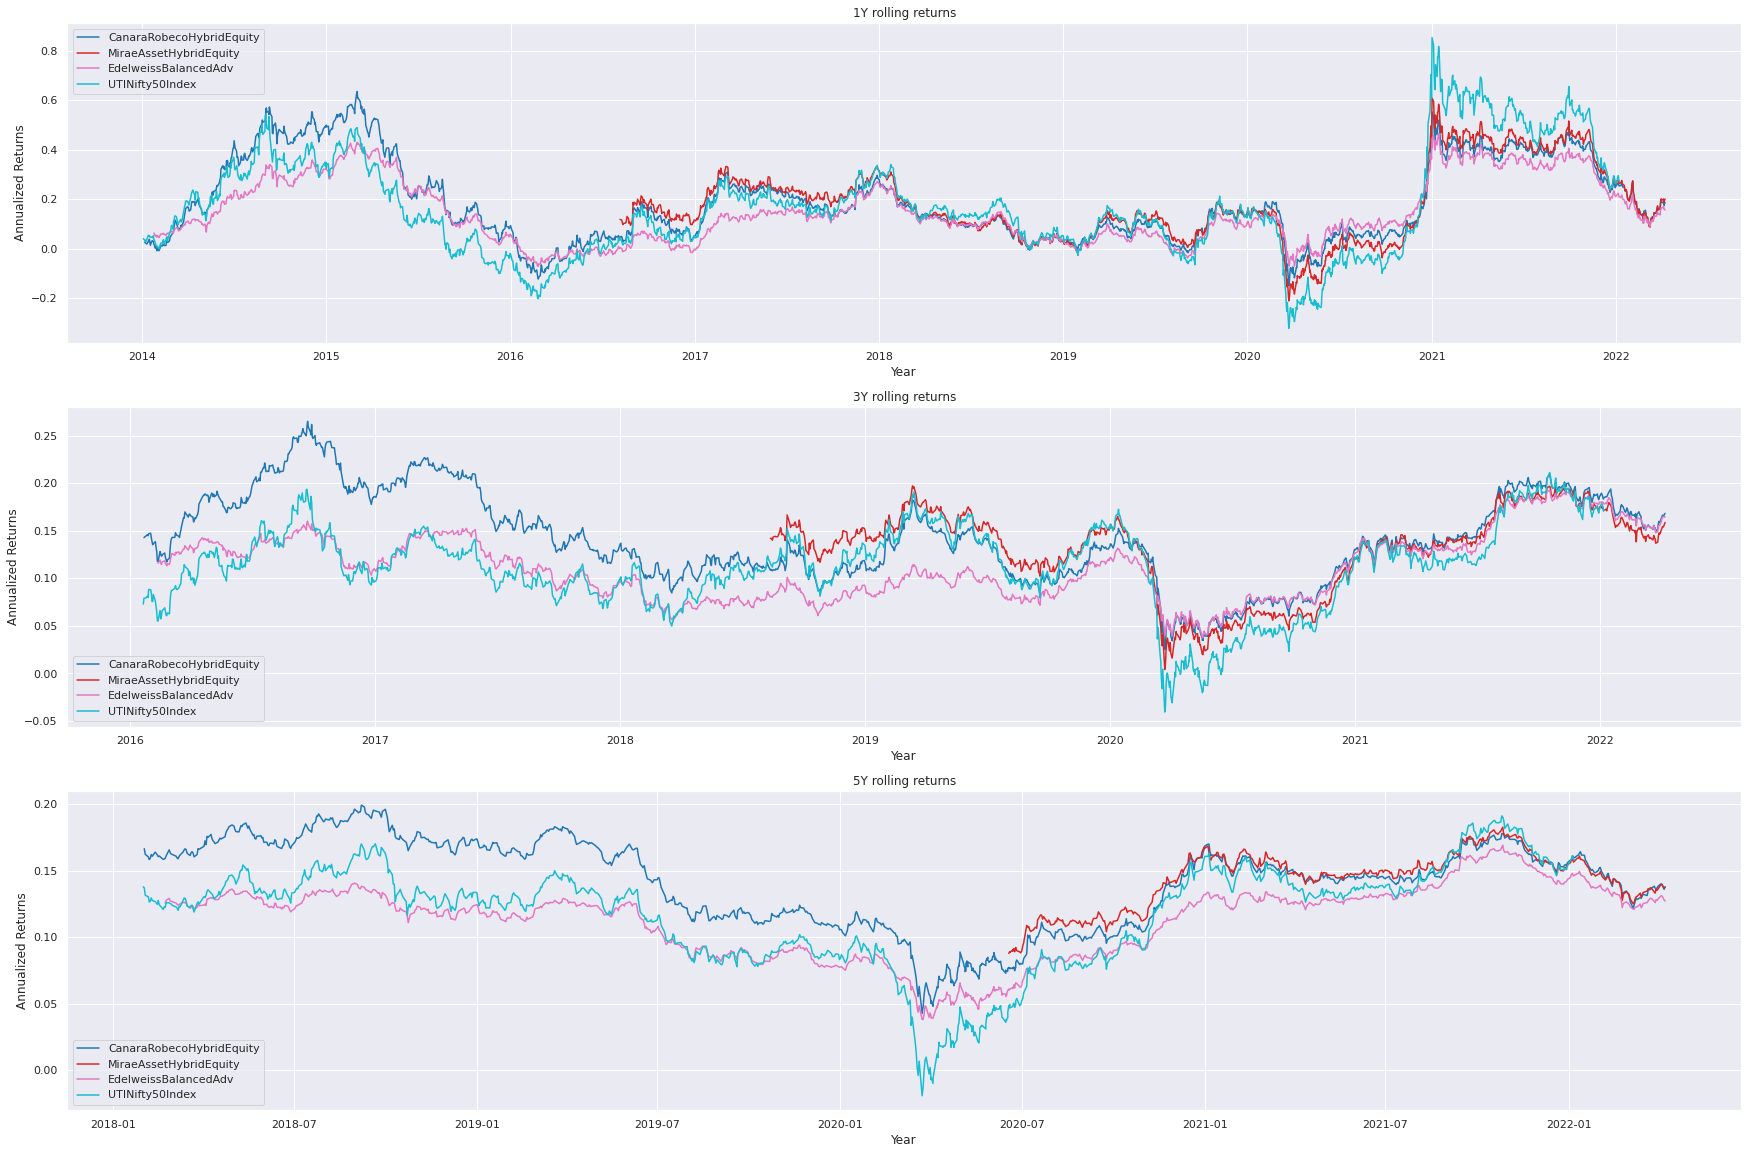

In [67]:
num_years = [1,3,5]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(30, 20))

colors = pl.cm.tab10(np.linspace(0,1,len(fund_names)))

for i , num_year in enumerate(num_years): 
    for j, fund_name in enumerate(fund_names):
        ax[i].plot(mf_dfs[fund_name]['date'], mf_dfs[fund_name][f'{fund_name}_{num_year}Y_rolling_ret'], color=colors[j])
        ax[i].set_title(f'{num_year}Y rolling returns')
        ax[i].set_xlabel('Year')
        ax[i].set_ylabel('Annualized Returns')
        ax[i].legend(fund_names, loc='best')
plt.show()

In [68]:
mfs_comparison = pd.DataFrame(data={
    'fund_name': fund_names,
    '1Y_ret_mean': mf_1Y_ret_mean,
    '3Y_ret_mean': mf_3Y_ret_mean,
    '5Y_ret_mean': mf_3Y_ret_mean,
    '1Y_ret_std': mf_1Y_ret_std,
    '3Y_ret_std': mf_3Y_ret_std,
    '5Y_ret_std': mf_5Y_ret_std
})

mfs_comparison.set_index('fund_name', inplace=True)

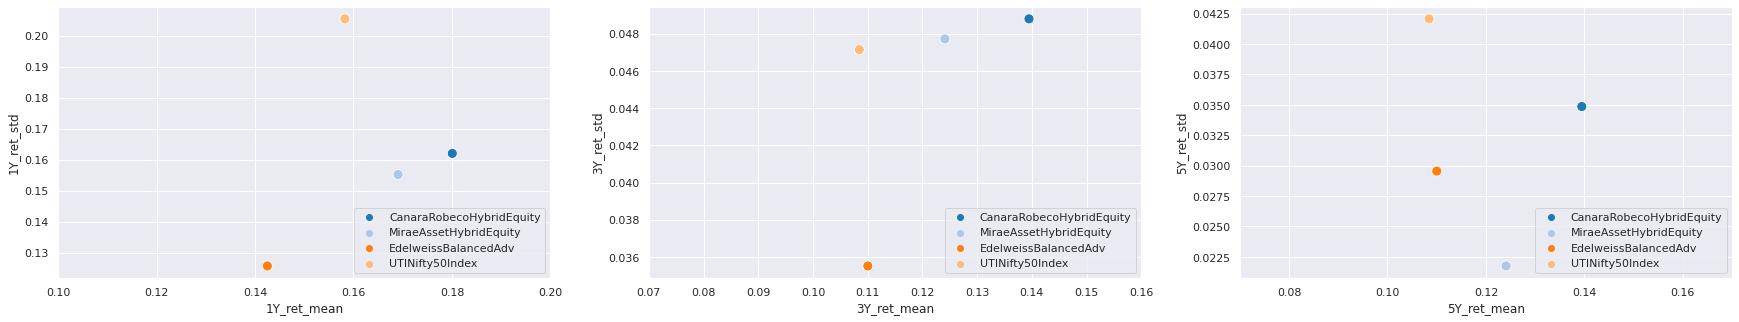

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 5))

ax[0].set(xlim=(0.1, 0.24))
sns.scatterplot(data=mfs_comparison, x='1Y_ret_mean', y='1Y_ret_std', hue='fund_name', ax=ax[0], s=100, palette='tab20')
ax[0].legend(loc='lower right')
ax[0].set_xlim([0.1, 0.2])

ax[1].set(xlim=(0.07, 0.16))
sns.scatterplot(data=mfs_comparison, x='3Y_ret_mean', y='3Y_ret_std', hue='fund_name', ax=ax[1], s=100, palette='tab20')
ax[0].set_xlim([0.1, 0.2])
ax[1].legend(loc='lower right')

ax[2].set(xlim=(0.07, 0.17))
sns.scatterplot(data=mfs_comparison, x='5Y_ret_mean', y='5Y_ret_std', hue='fund_name', ax=ax[2], s=100, palette='tab20')
ax[0].set_xlim([0.1, 0.2])
ax[2].legend(loc='lower right')

plt.show()